In [20]:
import os
os.environ['OPENBLAS_NUM_THREADS'] ='40'
import numpy as np

import matplotlib.pyplot as plt
import sklearn
import scipy
from scipy.io import loadmat
from scipy.io import savemat
import matplotlib.pyplot as plt 
import pandas as pd
import struct
import json
import sys
import seaborn as sns 
from scipy import signal, stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture as GMM

In [3]:
data_burst_by_time = np.load('/content/gdrive/My Drive/Burst_data/data_burst_by_time.npy').T  # culture wise concatenated 
data_burst_by_time_shuffled = np.random.permutation(data_burst_by_time)
print("Averaged over channels: ", data_burst_by_time.shape)
print(data_burst_by_time.shape)
print(data_burst_by_time_shuffled.shape)

Averaged over channels:  (13092, 3410)
(13092, 3410)
(13092, 3410)


In [4]:
dataset_cutted = data_burst_by_time[:,1000:2500] # 1. cut 1000 - 2500 2. cut 1200 - 2200
dataset_cutted2 = data_burst_by_time[:,1200:2200]
dataset_cutted2_shuffled = np.random.permutation(dataset_cutted2)
print("First Cut: ", dataset_cutted.shape)
print("Second Cut: ", dataset_cutted2.shape)
print(dataset_cutted2_shuffled.shape)

First Cut:  (13092, 1500)
Second Cut:  (13092, 1000)
(13092, 1000)


In [0]:
from matplotlib import cm
import warnings


def plot_cluster_representatives(burst_data, labels, n_clusters,figsize=(30,15)):
    representatives = []
    for i in range(n_clusters):
        class_i = burst_data[np.where(labels == i)]
        representative = np.mean(class_i, axis = 0)
        quantile1 = np.quantile(class_i, 0.25, axis=0)
        quantile3 = np.quantile(class_i, 0.75, axis=0)
        median = np.median(class_i, axis = 0)
    
        representatives.append([representative,quantile1,quantile3,median])

    fig = plt.figure(figsize=figsize)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    
    if n_clusters < 10:
        colors = ["C" + str(i) for i in range(n_clusters)]
    else:
        colors = cm.rainbow(np.linspace(0, 1, n_clusters))
    rows = int(np.ceil(n_clusters/3)) 
    for i in range(n_clusters):
        if i < n_clusters:
            count = i + 1
        ax = fig.add_subplot(rows, 3, count)
        ax.set_ylim([0,max(representatives[i][2]) * 1.1])
        
        for j,representative in enumerate(representatives):
            if i == j:
                ax.plot(representative[0], color = colors[i], lw = 3, label = "Mean")
                ax.plot(representative[3], color = colors[i], lw = 3, ls = '--', label = "Median")
                ax.fill_between(range(len(representative[1])), representative[1],representative[2],color = colors[i],alpha=0.5, label = "Q1-Q3")
                #ax.plot(representative[1], color = colors[i], lw = 1, ls = '--')
                #ax.plot(representative[2], color = colors[i], lw = 1, ls = '--')
                ax.legend()
            else:
                ax.plot(representative[0], color = colors[j], alpha=0.3)
                #ax.plot(representative[1], color = colors[j], alpha=0.3)
                #ax.plot(representative[2], color = colors[j], alpha=0.3)
            
            ax.set_xlabel("Time")
            ax.set_title("Class %i " % i)
            

def plot_normalized_cluster_examples(burst_data, labels, n_clusters):
    fig = plt.figure(figsize=(30,15))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    rows = int(np.ceil(n_clusters/3)) 
    if n_clusters < 10:
        colors = ["C" + str(i) for i in range(n_clusters)]
    else:
        colors = cm.rainbow(np.linspace(0, 1, n_clusters))
        
    for i in range(n_clusters):
        #class_i = burst_data[np.where(labels == i)]
        class_i = np.random.permutation(burst_data[np.where(labels == i)])
        if i < n_clusters:
            count = i + 1
        ax = fig.add_subplot(rows, 3, count)
        
        for j,burst in enumerate(class_i[0:10]):
            amplitude = max(burst)
            normalized_burst = burst/amplitude
            ax.plot(normalized_burst)#, color = colors[i])
        
        ax.set_xlabel("Time")
        ax.set_title("Class %i " % i)
        
        
def plot_cluster_examples(burst_data, labels, n_clusters):
  
  if n_clusters < 10:
      colors = ["C" + str(i) for i in range(n_clusters)]
  else:
      colors = cm.rainbow(np.linspace(0, 1, n_clusters))

  fig = plt.figure(figsize=(30,25))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)    
  rows = int(np.ceil(n_clusters/3)) 
  for i in range(n_clusters):
      class_i = burst_data[np.where(labels == i)]
      class_i = np.random.permutation(class_i)
      if i < cutoff:
          count = i + 1
      ax = fig.add_subplot(rows, 3, count)
      ax.set_xlabel("Time")
      ax.set_title("Class %i " % i)
      for burst in class_i[0:200]:
          ax.plot(burst)

In [0]:
def k_fold_split(data,k_folds = 5): 
  fold_length = int(data.shape[0]/k_folds) #length of each fold
  valid_folds = []
  train_folds = []
  for i in range(k_folds-1):
    valid_folds += [data[i*fold_length:(i+1)*fold_length]]
    train_folds += [np.delete(data, range(i*fold_length,(i+1)*fold_length), axis = 0)]
      
  valid_folds += [data[(k_folds-1)*fold_length:]]
  train_folds += [np.delete(data, range((k_folds-1)*fold_length, len(data)), axis = 0)]
  return train_folds, valid_folds

In [0]:
n_total = dataset_cutted2.shape[0]
n_shuffled = np.random.RandomState(seed=42).permutation(n_total)

train_folds, valid_folds = k_fold_split(n_shuffled, k_folds = 5) #returns indicies referring to original data


In [0]:
np.save('/content/gdrive/My Drive/Burst_data/train_folds_gmm',train_folds)
np.save('/content/gdrive/My Drive/Burst_data/valid_folds_gmm',valid_folds)

In [8]:
print(train_folds[0])
# 9256  407 7745 ... 5390  860 7270

[9256  407 7745 ... 5390  860 7270]


In [0]:
def cv_gmm_models(X,train_folds, valid_folds, clusters,n_init=100, max_iter=100, bic_file = None, scores_file = None, valid_prediction_file = None, train_prediction_file=None, valid_fitted_prediction_file = None):
  if bic_file:
    print("Load Files from drive!")
    bics = list(np.load(bic_file,allow_pickle=True))
    scores = list(np.load(scores_file,allow_pickle=True))
    predictions_valid = list(np.load(valid_prediction_file,allow_pickle=True))
    predictions_train = list(np.load(train_prediction_file,allow_pickle=True))
    predictions_valid_fitted = list(np.load(valid_fitted_prediction_file,allow_pickle=True))
  else:
    bics = [] # for each fold and each cluster 
    scores = [] # for each fold and each cluster
    predictions_valid = []
    predictions_train = []
    predictions_valid_fitted = []
    
  for c in clusters:
    print("Fitting GMM with %d clusters:" % c)
    bics_c = []
    scores_c = []
    predictions_valid_c = []
    predictions_train_c = []
    predictions_valid_fitted_c = []
    
    for i, valid_fold in enumerate(valid_folds): 
      print("On %d Fold" % (i+1))
      valid_set = X[valid_fold]
      train_set = X[train_folds[i]]
      
      gmm= GMM(c, n_init=n_init, max_iter=max_iter).fit(train_set) 
      gmm_valid = GMM(c, n_init=n_init, max_iter=max_iter).fit(valid_set) 
      
      
      bics_c.append((gmm.bic(train_set),gmm_valid.bic(valid_set)))
      scores_c.append((gmm.score(train_set),gmm.score(valid_set)))
      
      print("Predicting Training Set!")
      predictions_train_c.append(gmm.predict(train_set))
      
      print("Predicting Validation Set!")
      predictions_valid_c.append(gmm.predict(valid_set))
      
      print("Prediction Vlaidation Set after fitting separately!")
      predictions_valid_fitted_c.append(gmm_valid.predict(valid_set))
    
    bics.append(bics_c)
    scores.append(scores_c)
    predictions_train.append(predictions_train_c)
    predictions_valid.append(predictions_valid_c)
    predictions_valid_fitted.append(predictions_valid_fitted_c)
    
    #np.save('/content/gdrive/My Drive/Burst_data/bics_%d_clusters' % c, bics)
    #np.save('/content/gdrive/My Drive/Burst_data/scores_%d_clusters' % c, scores)
    #np.save('/content/gdrive/My Drive/Burst_data/predictions_valid%d_clusters' % c, predictions_valid)
    #np.save('/content/gdrive/My Drive/Burst_data/predictions_train%d_clusters' % c, predictions_train)
    #np.save('/content/gdrive/My Drive/Burst_data/predictions_valid_fitted%d_clusters' % c, predictions_valid_fitted)
    
  return bics, scores, predictions_train, predictions_valid, predictions_valid_fitted

In [0]:
clusters = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20] 
bics, scores, predictions_train, predictions_valid, predictions_valid_fitted = cv_gmm_models(dataset_cutted2,train_folds,valid_folds,clusters,n_init=10)

In [0]:
np.save('/content/gdrive/My Drive/Burst_data/bics_clusters', bics)
np.save('/content/gdrive/My Drive/Burst_data/scores_clusters', scores)
np.save('/content/gdrive/My Drive/Burst_data/predictions_valid_clusters', predictions_valid)
np.save('/content/gdrive/My Drive/Burst_data/predictions_train_clusters', predictions_train)
np.save('/content/gdrive/My Drive/Burst_data/predictions_valid_fitted_clusters', predictions_valid_fitted)

In [0]:
bics = list(np.load('/content/gdrive/My Drive/Burst_data/bics_20_clusters.npy',allow_pickle=True))
scores = list(np.load('/content/gdrive/My Drive/Burst_data/scores_20_clusters.npy',allow_pickle=True))
predictions_valid = list(np.load('/content/gdrive/My Drive/Burst_data/predictions_valid20_clusters.npy',allow_pickle=True))
predictions_train = list(np.load('/content/gdrive/My Drive/Burst_data/predictions_train20_clusters.npy', allow_pickle = True))
predictions_valid_fitted = list(np.load('/content/gdrive/My Drive/Burst_data/predictions_valid_fitted20_clusters.npy', allow_pickle = True))

In [0]:
bics = list(np.load('/content/gdrive/My Drive/Burst_data/bics_clusters.npy',allow_pickle=True))
scores = list(np.load('/content/gdrive/My Drive/Burst_data/scores_clusters.npy',allow_pickle=True))
predictions_valid = list(np.load('/content/gdrive/My Drive/Burst_data/predictions_valid_clusters.npy',allow_pickle=True))
predictions_train = list(np.load('/content/gdrive/My Drive/Burst_data/predictions_train_clusters.npy', allow_pickle = True))
predictions_valid_fitted = list(np.load('/content/gdrive/My Drive/Burst_data/predictions_valid_fitted_clusters.npy', allow_pickle = True))

In [0]:
def plot_bic_scores(bics,n_clusters,gradient_plot = True):
        
    plt.figure(figsize = (20,10))
    plt.plot(n_clusters,bics, label='BIC')
    #plt.axvline(n_clusters[np.argmin(bics)], c="red", linestyle = "--")
    #plt.axhline(min(bics), c="red", linestyle = "--")
    #plt.xticks(list(plt.xticks()[0]) + [np.argmin(bics) + 1] )
    #plt.yticks(list(plt.yticks()[0])[0:-1] + [min(bics)])
    plt.title("BIC Scores", fontsize=20) 
    plt.xticks(n_clusters)
    plt.xlabel("Number of clusters")
    plt.ylabel("Score")
    plt.legend()
    #plt.yscale("symlog")
    
    if gradient_plot:
        plt.figure(figsize = (20,10))
        plt.plot(n_clusters, np.gradient(bics), label='BIC')
        plt.title("Gradient of BIC Scores", fontsize=20)
        plt.xticks(n_clusters)
        plt.xlabel("Number of clusters")
        plt.ylabel("grad(BIC)")
        plt.legend()

In [0]:
train_bics = np.asarray(bics)[:,:,0]
valid_bics = np.asarray(bics)[:,:,1]

train_scores = np.asarray(scores)[:,:,0]
valid_scores = np.asarray(scores)[:,:,1]

In [103]:
print(train_bics.shape)

(20, 5)


In [13]:
def plot_bics_scores(train_bics,valid_bics): 
 
 
    fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(50,20))
    fig.subplots_adjust(hspace=0.5, wspace=0.2)
    plt.rc('xtick', labelsize=30)
    plt.rc('ytick', labelsize=30) 
  
    n_clusters = range(1,len(train_bics)+1)
    mean_train_bics = np.mean(train_bics, axis = 1)
    mean_valid_bics = np.mean(valid_bics, axis = 1)
  
    err_train_bics = np.std(train_bics,axis = 1)
    err_valid_bics = np.std(valid_bics,axis = 1)
  
  
    axes[0].errorbar(n_clusters, mean_train_bics, yerr=err_train_bics)
  
    axes[0].set_title("BIC Scores (Training Folds)", fontsize=40) 
    axes[0].set_xticks(n_clusters)
    axes[0].set_xlabel("Number of clusters",fontsize=30)
    axes[0].set_ylabel("Score",fontsize=30) 
  
  
    axes[1].errorbar(n_clusters, mean_valid_bics, yerr=err_valid_bics)
  
    axes[1].set_title("BIC Scores (Validation Folds)", fontsize=40) 
    axes[1].set_xticks(n_clusters)
    axes[1].set_xlabel("Number of clusters",fontsize=30)
    axes[1].set_ylabel("Score",fontsize=30) 
  
  

def plot_per_sample_log_likelihood(train_scores,valid_scores):
    fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(50,20))
    fig.subplots_adjust(hspace=0.5, wspace=0.2)
    plt.rc('xtick', labelsize=30)
    plt.rc('ytick', labelsize=30) 
  
    n_clusters = range(1,len(train_scores)+1)
    mean_train_scores = np.mean(train_scores, axis = 1)
    mean_valid_scores = np.mean(valid_scores, axis = 1)
  
    err_train_scores = np.std(train_scores,axis = 1)
    err_valid_scores = np.std(valid_scores,axis = 1)
  
  
    axes[0].errorbar(n_clusters, mean_train_scores, yerr=err_train_scores)
  
    axes[0].set_title("per-sample average log-likelihood (Training Folds)", fontsize=40) 
    axes[0].set_xticks(n_clusters)
    axes[0].set_xlabel("Number of clusters",fontsize=30)
    axes[0].set_ylabel("Score",fontsize=30) 
  
  
    axes[1].errorbar(n_clusters, mean_valid_scores, yerr=err_valid_scores)
  
    axes[1].set_title("per-sample average log-likelihood (Validation Folds)", fontsize=40) 
    axes[1].set_xticks(n_clusters)
    axes[1].set_xlabel("Number of clusters",fontsize=30)
    axes[1].set_ylabel("Score",fontsize=30) 

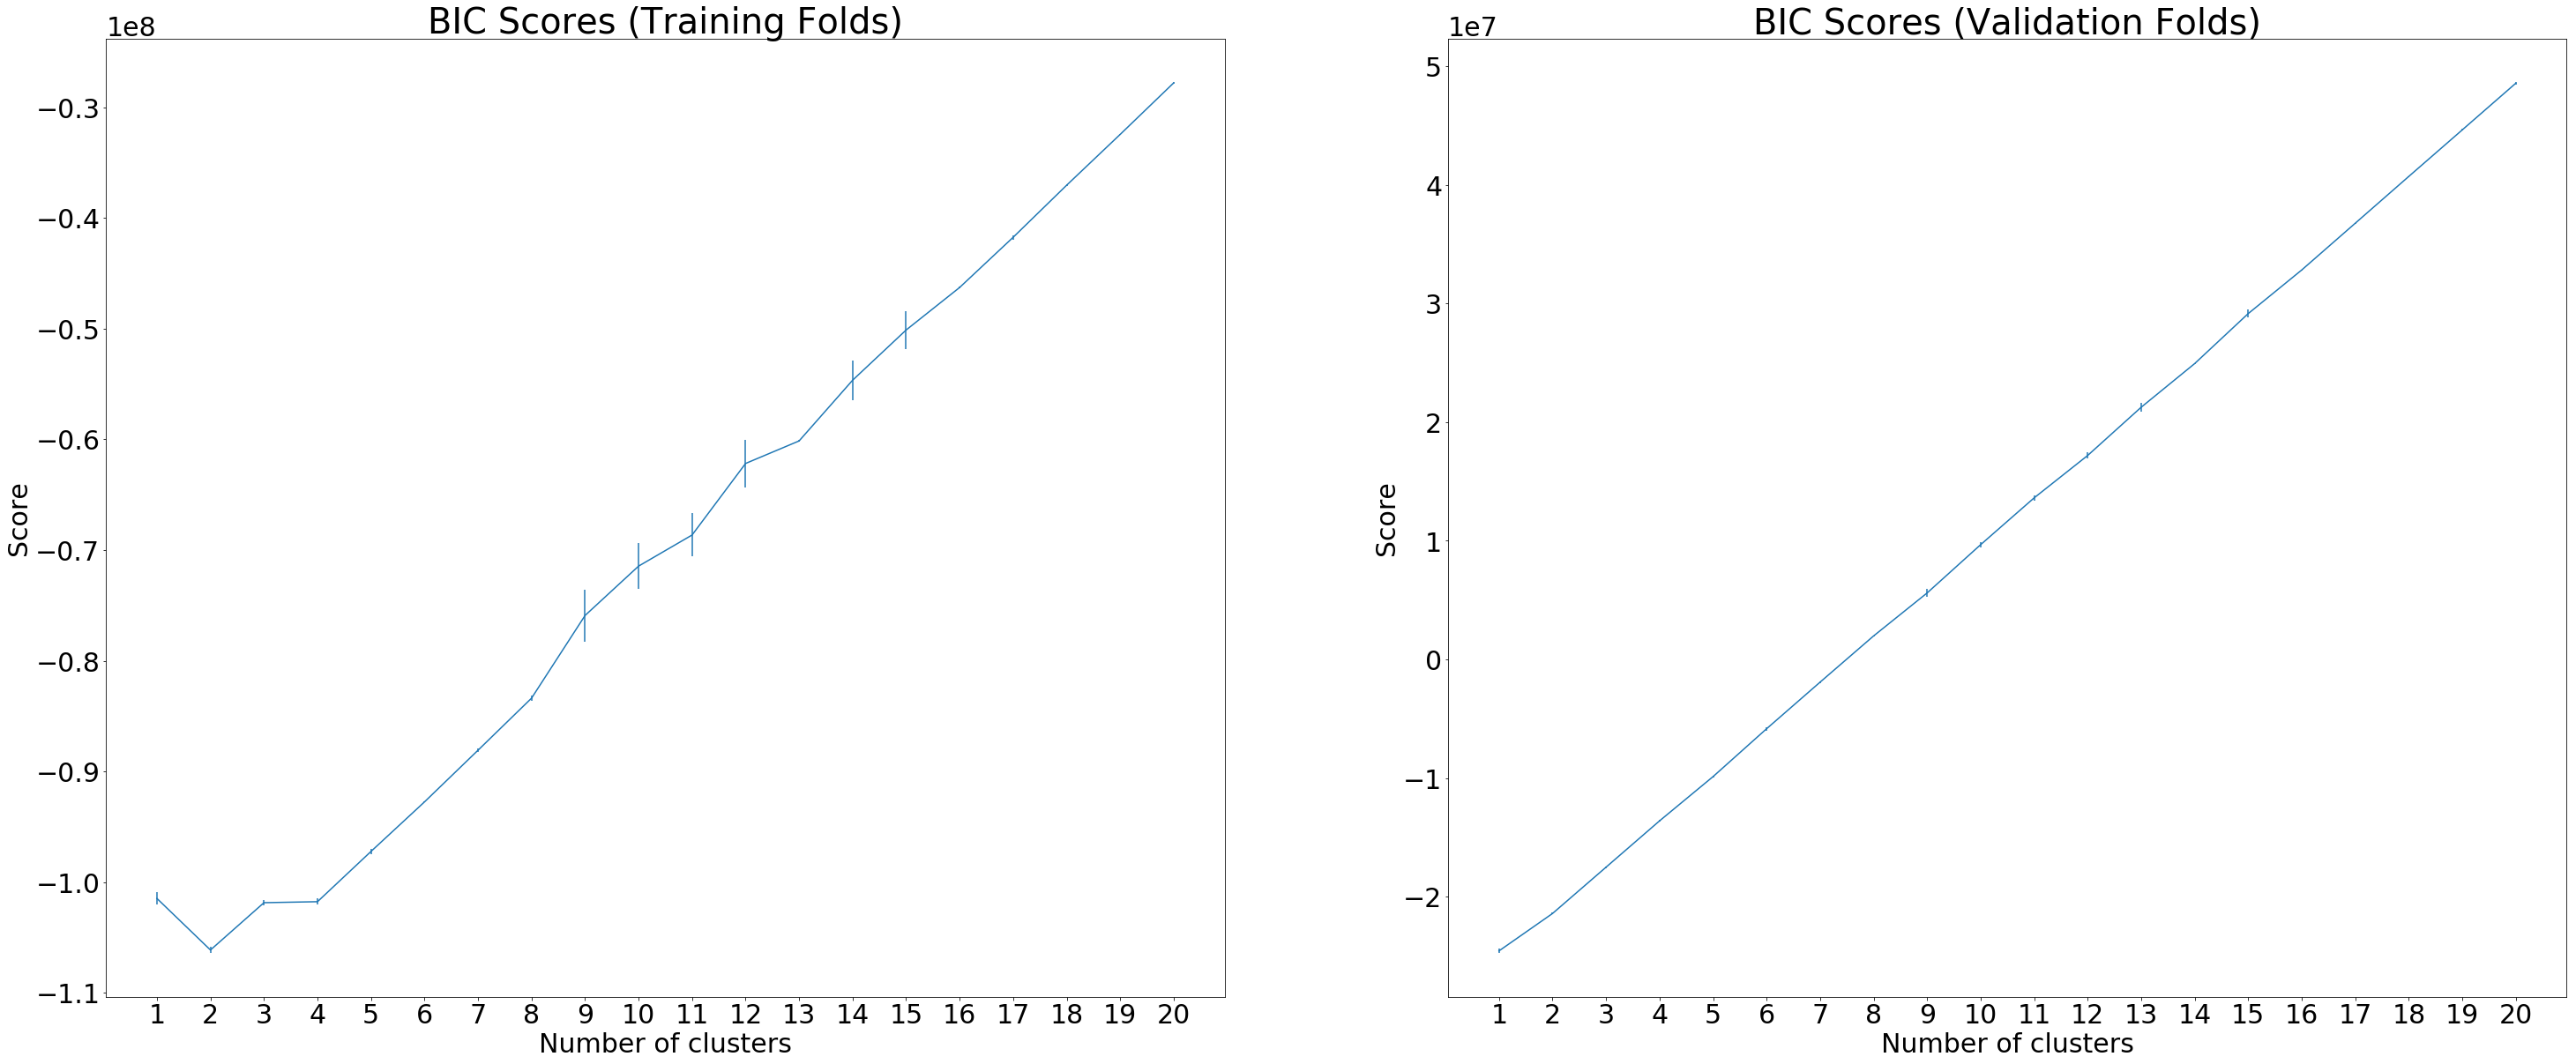

In [145]:
plot_bics_scores(train_bics,valid_bics)

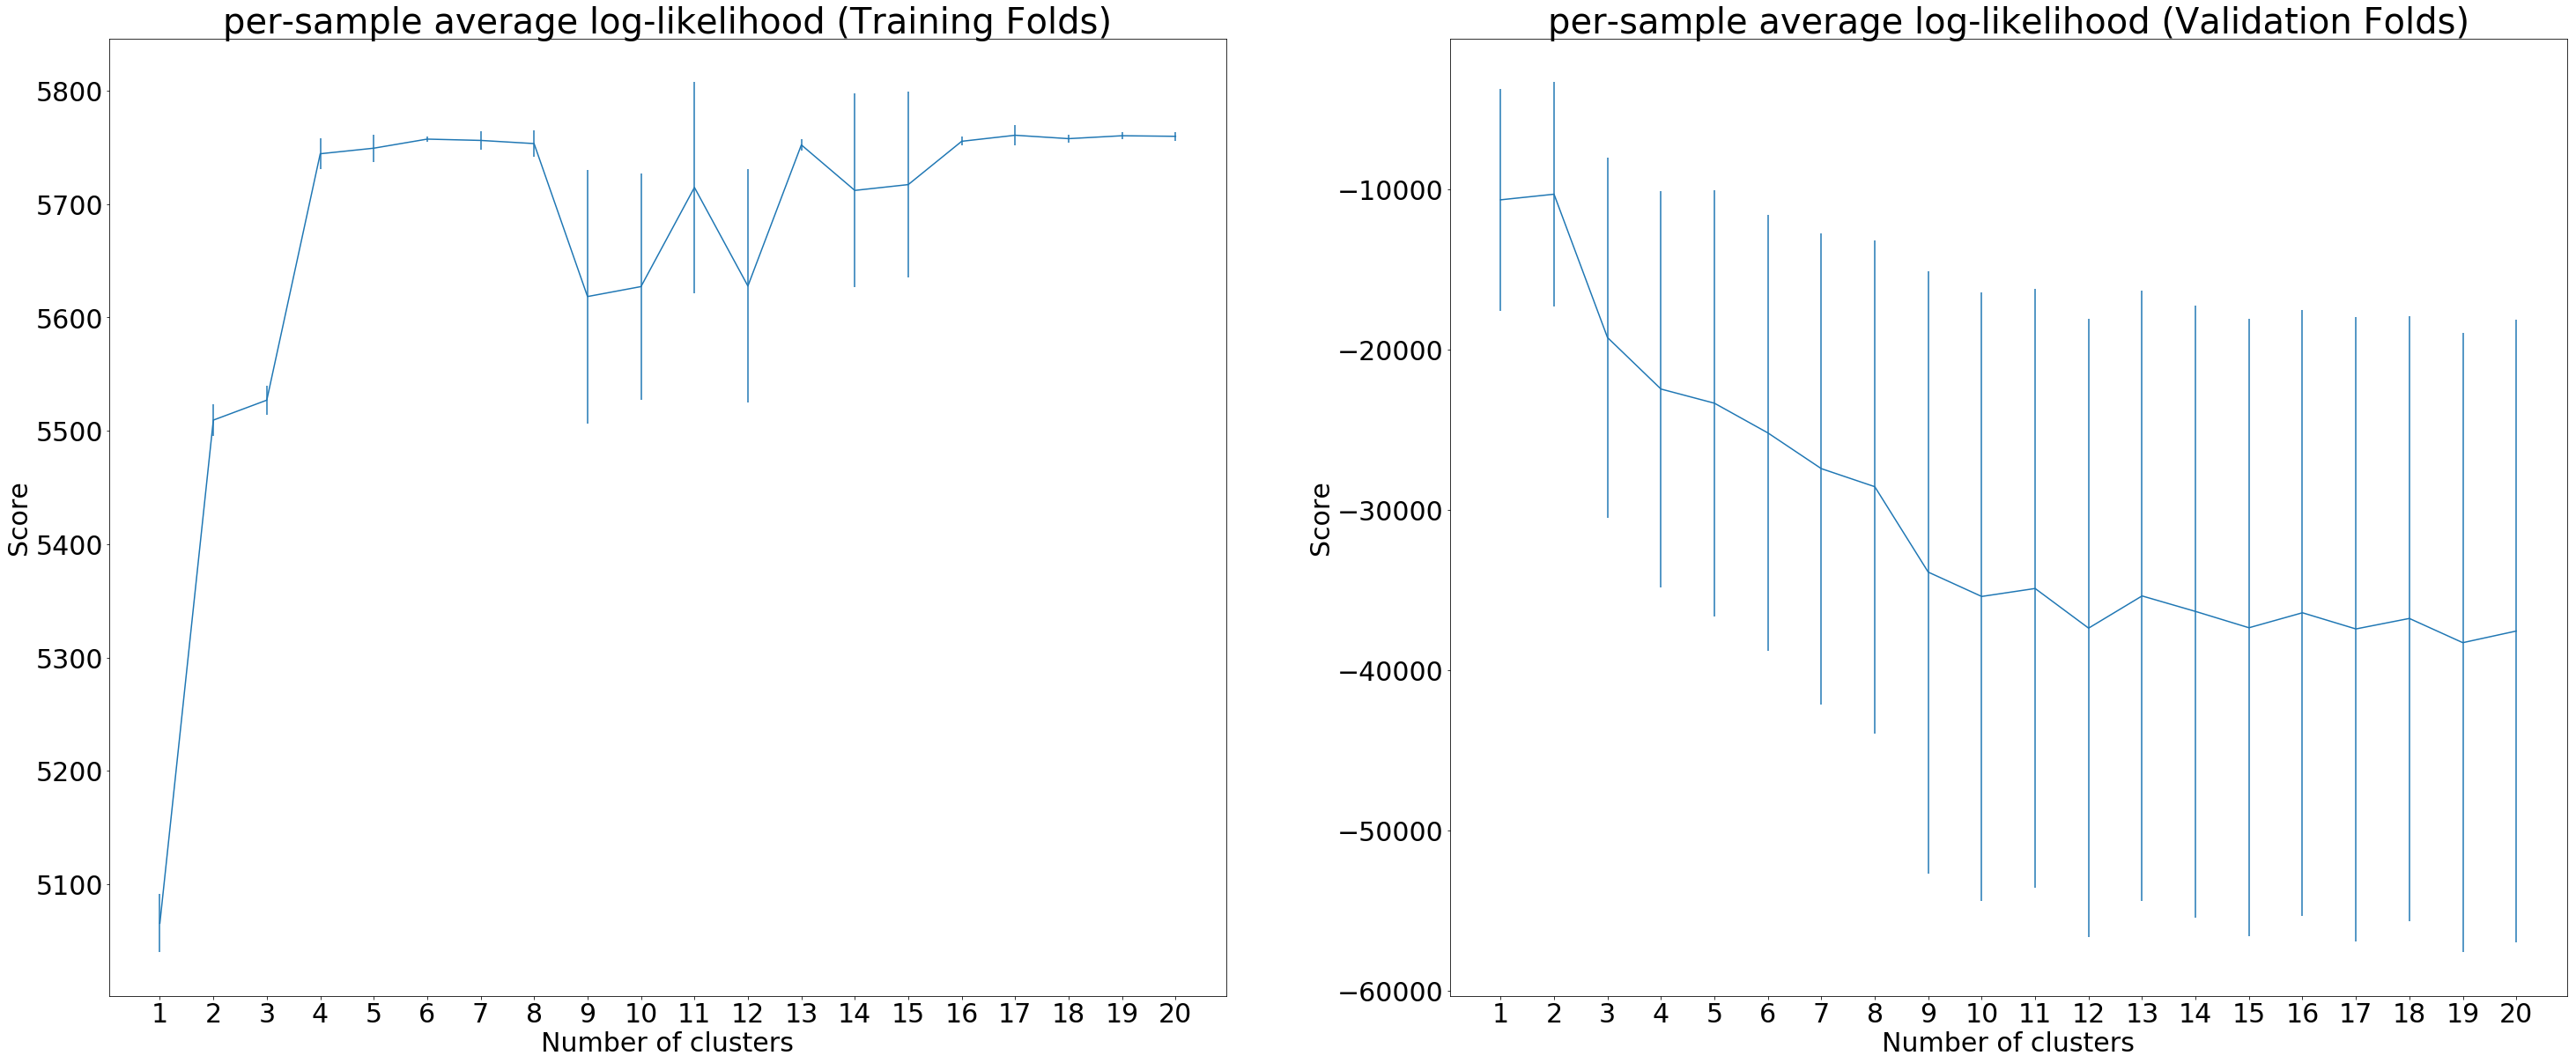

In [147]:
plot_per_sample_log_likelihood(train_scores,valid_scores)

In [3]:
data_dir = '../Data/'
sub_dir = '50_50_split/'

In [6]:
bics1 = list(np.load(data_dir + '50_50_split/bics_1.npy',allow_pickle=True)) # contains bic score for training and validation set since 50/50 split one file contains full info about bic 
bics2 = list(np.load(data_dir + '50_50_split/bics_2.npy',allow_pickle=True)) # contains bic score for training and validation set since 50/50 split one file contains full info about bic 

scores_1 = list(np.load(data_dir + '50_50_split/scores_1.npy',allow_pickle=True)) # scores for training and validation set 
scores_2 = list(np.load(data_dir + '50_50_split/scores_1.npy',allow_pickle=True))

predictions_valid_1 = list(np.load(data_dir + '50_50_split/predictions_valid_1.npy',allow_pickle=True)) # predictions of validation set 
predictions_valid_2 = list(np.load(data_dir + '50_50_split/predictions_valid_2.npy',allow_pickle=True))

predictions_train_1 = list(np.load(data_dir + '50_50_split/predictions_train_1.npy',allow_pickle=True)) # predictions of training set 
predictions_train_2 = list(np.load(data_dir + '50_50_split/predictions_train_2.npy',allow_pickle=True)) 

predictions_valid_fitted_1 = list(np.load(data_dir + '50_50_split/predictions_valid_fitted_1.npy',allow_pickle=True)) # predictions of validation set after fitting gmm on it
predictions_valid_fitted_2 = list(np.load(data_dir + '50_50_split/predictions_valid_fitted_2.npy',allow_pickle=True)) 

In [17]:
train_bics = np.stack((np.asarray(bics1)[:,0],np.asarray(bics2)[:,0]),axis=1)
valid_bics = np.stack((np.asarray(bics1)[:,1],np.asarray(bics2)[:,1]),axis=1)

train_scores = np.stack((np.asarray(scores_1)[:,0],np.asarray(scores_2)[:,0]),axis=1)
valid_scores = np.stack((np.asarray(scores_1)[:,1],np.asarray(scores_2)[:,1]),axis=1)

(20, 2)


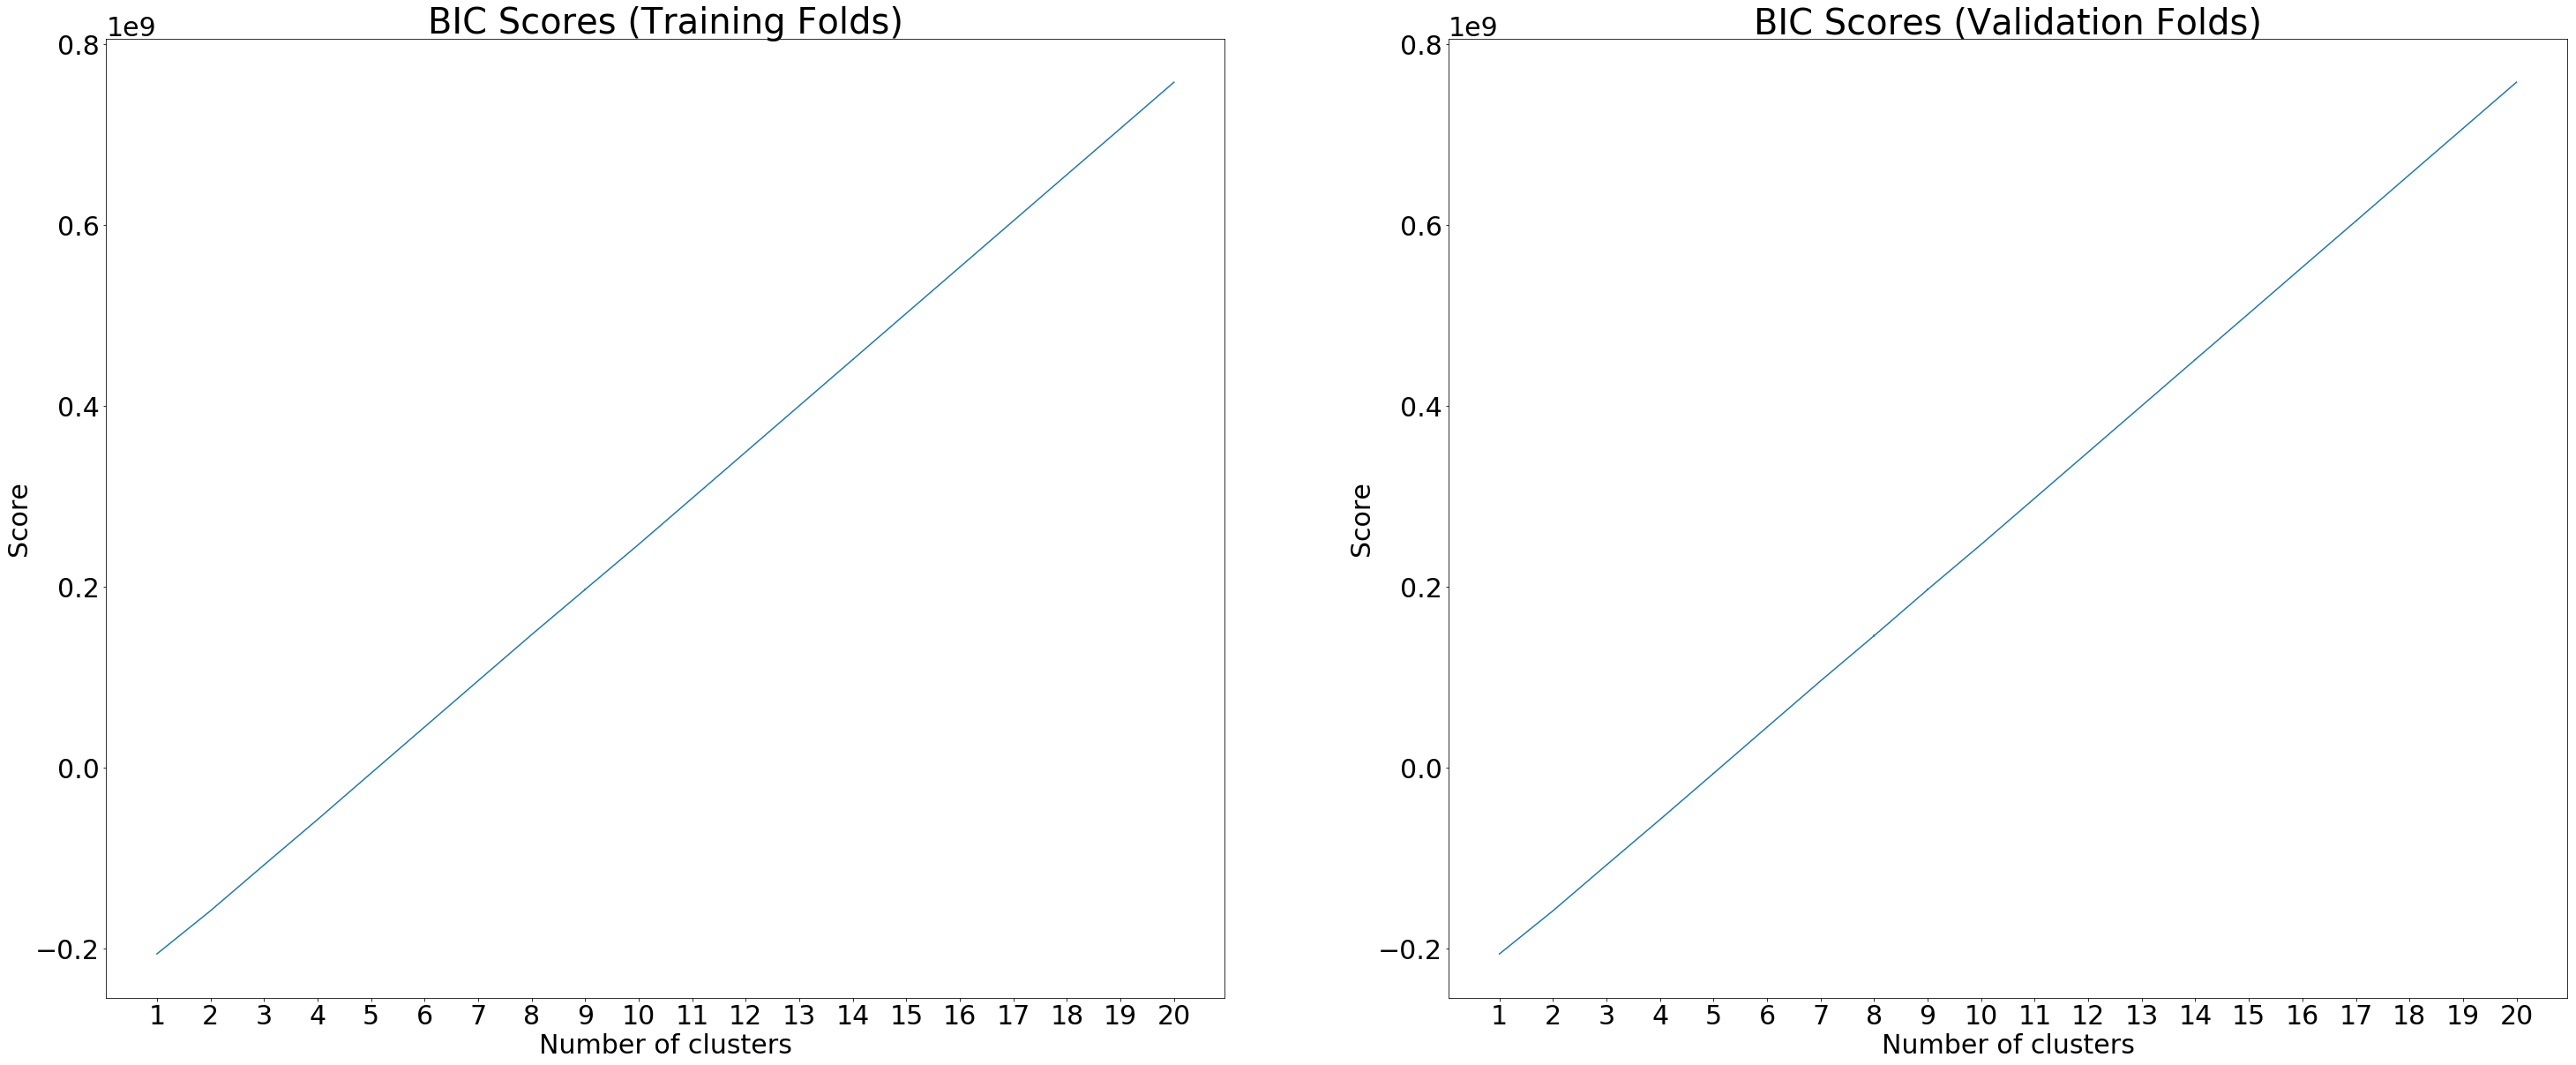

In [18]:
plot_bics_scores(train_bics,valid_bics)

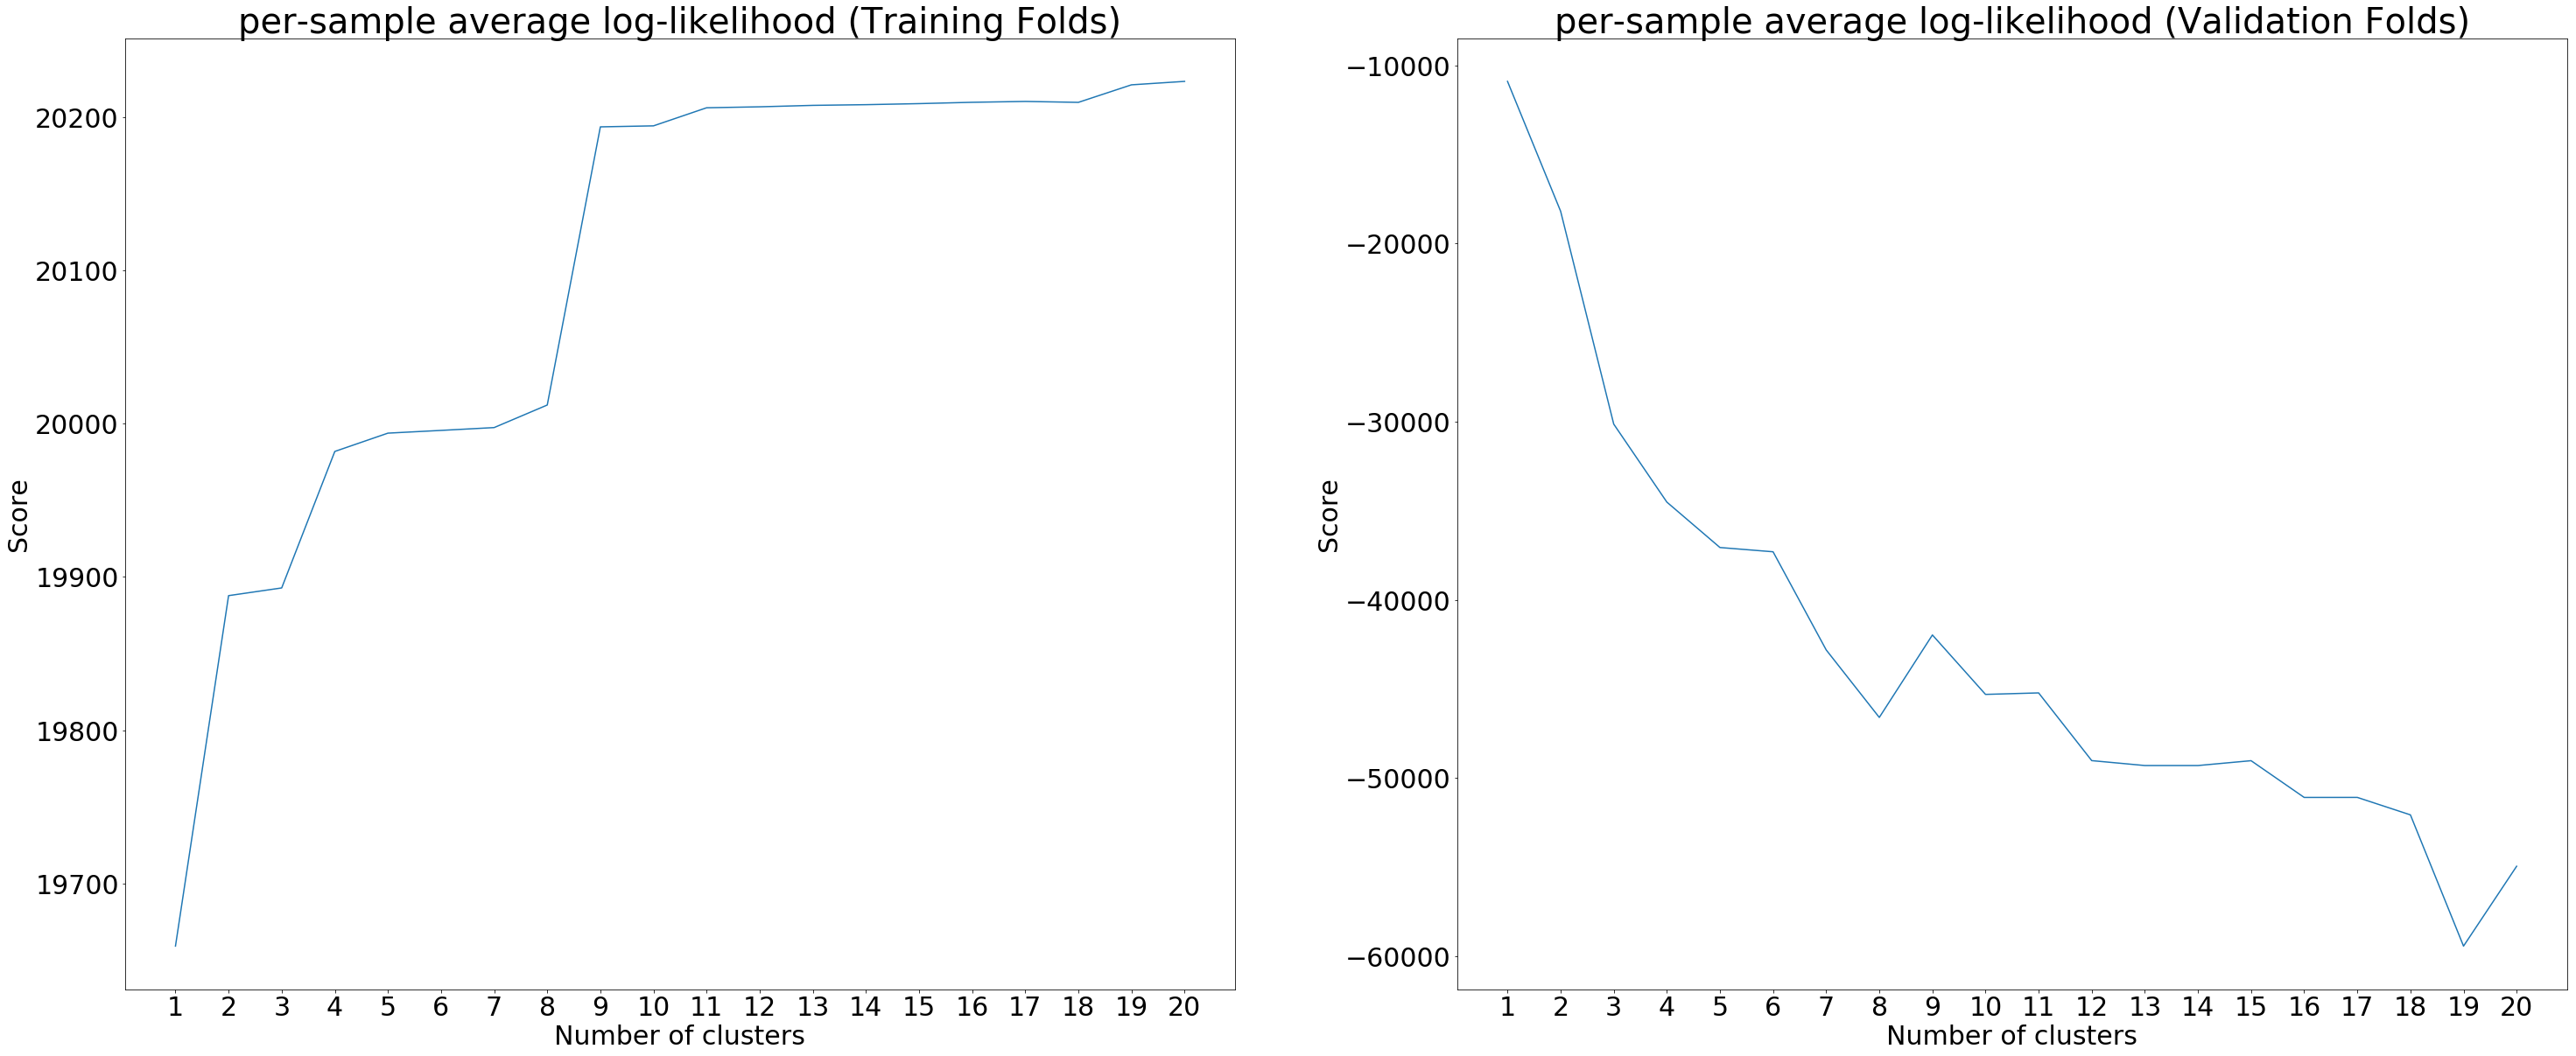

In [19]:
plot_per_sample_log_likelihood(train_scores,valid_scores)